# Sample Pipeline

This notebook shows an end to end radio interferometry pipeline from the simulation of the sky to the final image. The pipeline consists of three modules:

- Simulation
    - Sky module: OSKAR
    - Telescope module incl. calibration: OSKAR
- Processing
    - Calibration after observation: RASCIL
    - Deconvolution: RASCIL
- Analysis & comparison
    - Quantitative and qualitative analysis of algorithms

In [1]:
import sys
import oskar
import matplotlib
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from karabo.simulation import sky_model, telescope, observation, interferometer
from karabo.Imaging import imager, image

Detecting to be running in Jupyter Notebook --> Settings RASCIL Environment Variable


In [2]:
plt.style.use(astropy_mpl_style)

## Simulation

The sky and telescope simulation is currently provided completely by OSKAR.

### Sky Module

The sky module of OSKAR contains radiation sources, which are defined as array and can be passed to `oskar.Sky.from_array`.

In [3]:
# Set the numerical precision to use.


# Create a sky model containing three sources from a numpy array.
sky_data = np.array([
    [20.0, -30.0, 1, 0, 0, 0, 100.0e6, -0.7, 0.0, 0, 0, 0],
    [20.0, -30.5, 3, 2, 2, 0, 100.0e6, -0.7, 0.0, 600, 50, 45],
    [20.5, -30.5, 3, 0, 0, 2, 100.0e6, -0.7, 0.0, 700, 10, -10]])
sky = sky_model.SkyModel(sky_data)

### Telescope Module

Various observation parameters and meta information `params` must be passed to the telescope module `oskar.Interferometer` of OSKAR as `oskar.SettingsTree`.

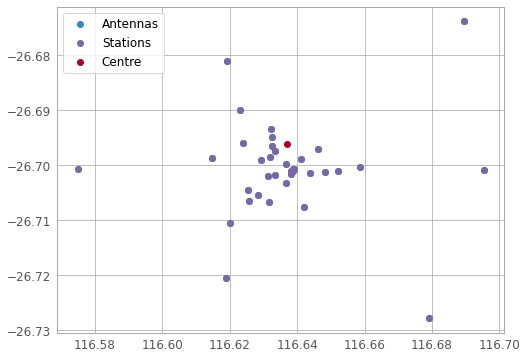

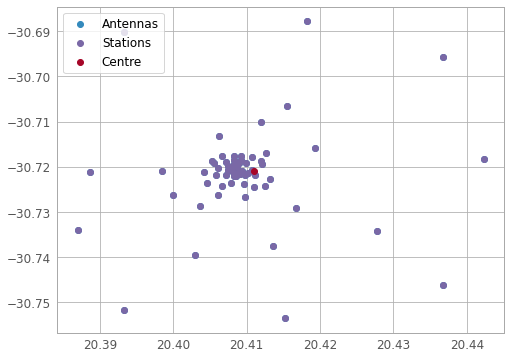

In [4]:
askap_tel = telescope.get_ASKAP_Telescope()
askap_tel.plot_telescope()

meerkat = telescope.get_MEERKAT_Telescope()
meerkat.plot_telescope()

### Observation Simulation

Now the sky module must be passed to the interferometer and the simulation of the observation must be started to generate the measurement set.

In [5]:
observation_settings = observation.Observation(100e6,
                                               phase_centre_ra_deg=20,
                                               phase_centre_dec_deg=-30,
                                               number_of_channels=64,
                                               number_of_time_steps=24)

interferometer_sim = interferometer.InterferometerSimulation(channel_bandwidth_hz=1e6)
visibility_askap = interferometer_sim.run_simulation(askap_tel, sky, observation_settings)
#visibility_meerkat = interferometer_sim.run_simulation(meerkat, sky, observation_settings)


W|                                                                   
W|== WARNING: No GPU capability available.
W|                                                                   


## Processing

After the observation is made with the telescope, a calibration of the measured data must be performed, followed by the reconstruction of the image.

### Calibration after Observation

toDo

In [6]:
# Code here

### Dirty Images

We can create dirty images of visibilites and display them as shown below

<SkyCoord (ICRS): (ra, dec) in deg
    (20., -30.)>


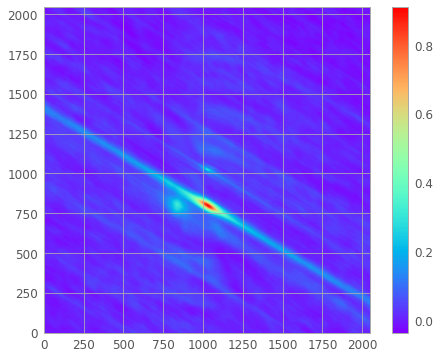

In [7]:
imager_askap = imager.Imager(visibility_askap, imaging_npixel=2048,
                        imaging_cellsize=3.878509448876288e-05)
dirty = imager_askap.get_dirty_image()
dirty.plot()

#
#imager_meerkat = imager.Imager(visibility_meerkat, imaging_npixel=2048,
#                        imaging_cellsize=3.878509448876288e-05)
#dirty_meerkat = imager_meerkat.get_dirty_image()
#dirty_meerkat.plot()

### Imaging

Start an mmclean algorithm with the visibilites.ms as an input to deconvolve. 
https://127.0.0.1:8787

In [8]:
imager_askap.ingest_chan_per_blockvis=1
imager_askap.ingest_vis_nchan=16
deconvolved, restored, residual = imager_askap.imaging_rascil(
                        clean_nmajor=0,
                        clean_algorithm='mmclean',
                        clean_scales=[0, 6, 10, 30, 60],
                        clean_fractional_threshold=.3,
                        clean_threshold=.12e-3,
                        clean_nmoment=5,
                        clean_psf_support=640,
                        clean_restored_output='integrated')

2022-04-29 13:13:46,671 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/cvoegele/development/SKA/karabo/examples/dask-worker-space/worker-hrw37d5g', purging
2022-04-29 13:13:46,671 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/cvoegele/development/SKA/karabo/examples/dask-worker-space/worker-aaaktlx1', purging
2022-04-29 13:13:46,671 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/cvoegele/development/SKA/karabo/examples/dask-worker-space/worker-yyogz8be', purging


LocalCluster(ac37480d, 'tcp://127.0.0.1:59701', workers=3, threads=9, memory=16.00 GiB)


2022-04-29 13:15:50,434 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.68 GiB -- Worker memory limit: 5.33 GiB
2022-04-29 13:15:50,451 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.78 GiB -- Worker memory limit: 5.33 GiB
2022-04-29 13:15:50,516 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.90 GiB -- Worker memory limit: 5.33 GiB
2022-04-29 13:15:56,215 - distributed.worke

2022-04-29 13:16:40,215 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.83 GiB -- Worker memory limit: 5.33 GiB
2022-04-29 13:16:40,416 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.74 GiB -- Worker memory limit: 5.33 GiB
2022-04-29 13:16:40,514 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 3.84 GiB -- Worker memory limit: 5.33 GiB


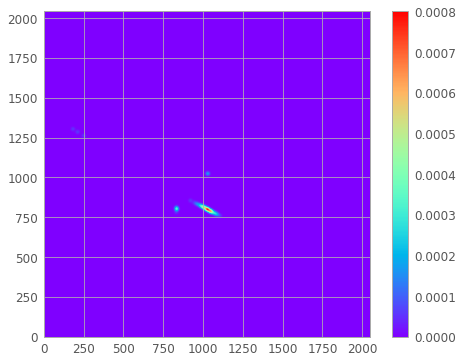

In [9]:
# any of the resulting output images of the clean algorithm can be displayed and saved.
deconvolved.plot()
deconvolved.save_as_fits("./deconv.fits")

## Analysis and Comparison

toDo

In [11]:
# matplotlib.use("Agg") from rascil_imager.py causes the problem that matplotlib isn't able to plot in the notebook
# If you want to plot here, you have to restart the kernel first, otherwise use an imager like "SAOImage DS9"
image_file = get_pkg_data_filename(deconvolved.file.path)
fits.info(image_file)

Filename: /var/folders/t_/dts5nn157lggfx17hwmndrt00000gn/T/tmpb7ywgkj5
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   (2048, 2048, 1, 16)   float64   


/var/folders/t_/dts5nn157lggfx17hwmndrt00000gn/T/ipykernel_5382/2802256723.py:2: RuntimeWarning: divide by zero encountered in log
  image_data = np.log(image_data.sum(axis=(0, 1)))
/var/folders/t_/dts5nn157lggfx17hwmndrt00000gn/T/ipykernel_5382/2802256723.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.colorbar()


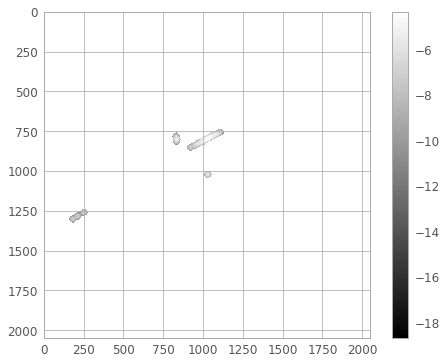

In [12]:
image_data = fits.getdata(image_file)
image_data = np.log(image_data.sum(axis=(0, 1)))
_ = plt.figure(figsize=(8, 6))
_ = plt.imshow(image_data, cmap='gray')
_ = plt.colorbar()